In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/data_asp.csv')
data.head()

,Fecha,Hora,Potencia Activa Global (W)
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [91]:
data.rename(columns={'Potencia Activa Global (W)':'Power'}, inplace=True)
data['Power'] = pd.to_numeric(data['Power'], errors='coerce')
data['Datetime'] = data['Fecha'] +" "+ data['Hora']
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)
data.drop(['Fecha', 'Hora'], axis=1,inplace=True)
data.set_index('Datetime', inplace=True)
data.head()

,Power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [97]:
grouped = data.groupby(data.index.month)['Power'].nana


False

In [75]:
nan = data[pd.isna(data['Power'])]

In [86]:
nan.groupby(by=nan.index.month)

False

In [76]:
data.loc['2006-12-21 11:23:00':'2006-12-21 11:55:00']

,Power
Datetime,
2006-12-21 11:23:00,NaN
2006-12-21 11:24:00,NaN
2006-12-21 11:25:00,0.246
2006-12-21 11:26:00,0.246
2006-12-21 11:27:00,0.244
2006-12-21 11:28:00,0.244
2006-12-21 11:29:00,0.244
2006-12-21 11:30:00,0.244
2006-12-21 11:31:00,0.242


In [77]:
data.interpolate(inplace=True)
data.loc['2006-12-21 11:23:00':'2006-12-21 11:55:00']

,Power
Datetime,
2006-12-21 11:23:00,0.244667
2006-12-21 11:24:00,0.245333
2006-12-21 11:25:00,0.246000
2006-12-21 11:26:00,0.246000
2006-12-21 11:27:00,0.244000
2006-12-21 11:28:00,0.244000
2006-12-21 11:29:00,0.244000
2006-12-21 11:30:00,0.244000
2006-12-21 11:31:00,0.242000


<Axes: xlabel='Datetime', ylabel='Power'>

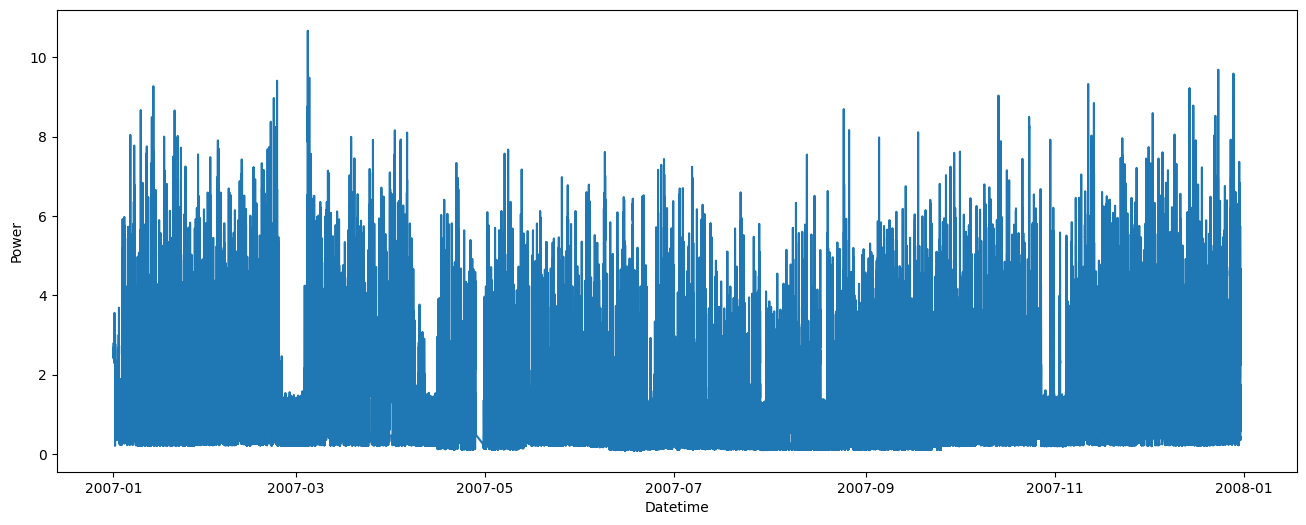

In [56]:
plt.figure(figsize=(16,6))
sns.lineplot(data.query("Datetime>='2007-01-01' & Datetime<= '2007-12-31'"), x='Datetime', y='Power')

In [5]:
from torch.utils.data import Dataset
import os 
import numpy as np

class APData(Dataset): 
    def __init__(self, file_path, transform = None):
        self.path = file_path
        self.transform = transform
        
        
